# Import Statements

In [1]:
import numpy as np
import networkx as nx
import math
import time
from scipy.interpolate import UnivariateSpline
import osmnx as ox
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform
from shapely.ops import unary_union
from networkx.algorithms.flow import shortest_augmenting_path

# Functions to Build Real-world Graph

In [2]:
MOORE_AFTER_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [3.9, 6, 11, 18, 27, 39, 54, 58, 84],
)
MOORE_BEFORE_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [6, 8, 11, 14, 17, 19, 22, 25, 28],
)

MOORE_SAFE_BREAKING_DISTANCE = lambda x: MOORE_AFTER_BREAK_SPLINE(
    x
) + MOORE_BEFORE_BREAK_SPLINE(x)

def moore(lanes: float, max_speed: float):
    return 1000 * max_speed / MOORE_SAFE_BREAKING_DISTANCE(max_speed) * lanes

def add_capacities(G, method=moore):

    G = G.copy()
    cap = []
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        raw_lanes = edge_data.get("lanes")
        
        if raw_lanes is None:
            lanes = 1
            
        elif isinstance(raw_lanes, str):
            lanes = int(raw_lanes) / 2  
            
        elif isinstance(raw_lanes, list):
            lanes = sum(int(x) for x in raw_lanes) / 2
            
        G[u][v][i]["upper"] = int(method(lanes, edge_data["speed_kph"]))
    return G

In [3]:
###don't need for max flow/quickest flow
def add_costs(G, costs:[int, np.ndarray] = 0):
    if type(costs) == int:
        for u,v,i in G.edges:
            G[u][v][i]['cost'] = costs
    else:
        count = 0
        for u,v,i in G.edges:
            G[u][v][i]['cost'] = costs[count]
    return G

In [4]:
def add_orig_dest(G, sup_dem:[int, np.ndarray]):
    if type(sup_dem) == int:
        for i in G.nodes:
            G._node[i]['sup_dem'] = sup_dem
    else:
        for i in G.nodes:
            G._node[i]['sup_dem'] = sup_dem[i]
    return G

In [5]:
def proj_lat_lngs(lats, lngs, G):
    #convert lat and longs to point geometry
    pnts_list = [Point((lng, lat)) for lat, lng in zip(lats, lngs)]
    
    #convert list of points into Geoseries of points
    #(EPSG:4326 is WGS84)
    pnts = gpd.GeoSeries(pnts_list, crs='epsg:4326')
    
    #convert points to CRS from OSMNX projection
    proj_pnts = pnts.to_crs(G.graph['crs'])
    return proj_pnts

def switch(key):
    if key == "Boulder":
        return (479800,4424260,489130,4429760)
    elif key == "Pueblo":
        return (5255180,4250280,514380,4423270)
    elif key == "Lyons":
        return (477230,4453570,476140,4430890)
    elif key == "Jefferson":
        return (489685,4379999,494940,4393420)
    elif key == "Sonoma":
        return (512007,4273277,525300,4255270)
    elif key == "Butte":
        # return (621540,4406520,599230,4400090)
        df_sinks = pd.read_csv('optimal_sinks.csv')  
        df_sources = pd.read_csv('sources.csv')
        lat = [df_sinks['lat'][0],df_sources['lat'][0]]
        long = [df_sinks['lon'][0],df_sources['lon'][0]]
        return (lat, long)
    else:
        raise Exception("Please enter a valid location.")
        exit()
        
###find nodes in network closestest to desired destinations
def orig_dest_nodes(network,location):
    ###do not test Butte yet (prjections might be weird)
    if location == "Butte":
        lat,long = switch(location)
        proj_sink_source = proj_lat_lngs(lat, long, network)
        orig=ox.distance.nearest_nodes(network,proj_sink_source.x[1],proj_sink_source.y[1],return_dist=False)
        dest=ox.distance.nearest_nodes(network,proj_sink_source.x[0],proj_sink_source.y[0],return_dist=False)
    else:
        lat_start,long_start,lat_end,long_end = switch(location)
        orig=ox.distance.nearest_nodes(network,lat_start,long_start,return_dist=False)
        dest=ox.distance.nearest_nodes(network,lat_end,long_end,return_dist=False)
    return orig, dest

# Functions to set up for Max Flow Alogirthm

In [6]:
def add_s_t(G,ten, time_horizon,**kwargs):
    start = time.time()
    ten_copy = ten.copy()
    orig_nodes = list(G.nodes)
    ten_nodes = list(ten_copy.nodes)
    removed_nodes_mat = kwargs.get('removed_nodes_mat',[ [] for _ in range(time_horizon)])

    sup_nodes = [x for x,y in ten_copy.nodes(data=True) if y['sup_dem'] > 0]
    dem_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] < 0]
    
    s = 0
    t = max(ten_nodes)+1
    
    ten_copy.add_node(s,name = f'{s}-{0}',level = 0,sup_dem = 0)
    ten_copy.add_node(t,name = f'{len(orig_nodes)}-{time_horizon-1}',level = time_horizon-1, sup_dem = 0)

    for i in sup_nodes:
        ten_copy.add_edge(s, i, cost = 0, upper = ten._node[i]['sup_dem'], lower = 0)

    for i in dem_nodes:
        for k in range(time_horizon-1):
            added = False
            if i in removed_nodes_mat[k+1]:
                ten_copy.add_edge((i+1) + ((k) * len(orig_nodes)),t, upper = -G._node[i]['sup_dem'], lower = 0)
                added = True
                break;
        if added is False:
            ten_copy.add_edge((i+1) + ((time_horizon-1) * len(orig_nodes)),t, upper = -G._node[i]['sup_dem'], lower = 0)

    end = time.time()
    print('Add Super Source and Sink Time: ',end-start)

    
    
    return ten_copy

In [7]:
###handled in TEN construction instead
def simplify_multigraph(graph):
    start = time.time()
    num_nodes = max(graph.nodes)
    edges = graph.edges
    
    simp_graph = nx.DiGraph()
    simp_graph.add_nodes_from(graph.nodes(data=True))
    
    for i in range(num_nodes+1):
        for j in range(num_nodes+1):
            if (i,j) in edges:
                num_edges = graph.number_of_edges(i,j)
                tot_cap = graph[i][j][num_edges-1]['upper']
                if num_edges > 1:
                    for k in range(1,num_edges):
                        tot_cap = tot_cap + graph[i][j][k]['upper']
                simp_graph.add_edge(i,j, upper = tot_cap, lower = 0)
    end = time.time()  
    print('Conversion to Digraph Time: ',end-start)
    return simp_graph

In [8]:
def color_max_flow(graph, flow_dict):
    edges = graph.edges

    for (i,j) in edges:
        graph[i][j]['color'] = (0,0,0)
        # print(f'({i},{j})')
        if i in flow_dict:
            if j in flow_dict[i]:
                if flow_dict[i][j] !=0:
                    graph[i][j]['color'] = (1,0,0)
                    
    return graph

# Functions to Include Fire Data with Graph

In [9]:
def geodesic_point_buffer(graph, lat, lon, radius):
    """
    Creates circles from given latitude, longitude, and radius
    :param lat: latitude from original data
    :param lon: longitude from original data
    :param radius: radius from original data
    """
    aeqd_proj = CRS.from_proj4(f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0")
    tfmr = Transformer.from_proj(aeqd_proj, aeqd_proj.geodetic_crs)
    buf = Point(0, 0).buffer(radius * 1609.34)  # distance in miles (converts from meters to miles)
    circle = Polygon(transform(tfmr.transform, buf).exterior.coords[:])
    net_trans = Transformer.from_crs(aeqd_proj.geodetic_crs, graph.graph['crs'])
    proj_circ = Polygon(transform(net_trans.transform,circle).exterior.coords[:])
    
    return proj_circ

In [10]:
def dist_to_fire(G, fire_polygon, **kwargs):
    smoke_polygon = kwargs.get('smoke_polygon',fire_polygon)
    ###find nodes inside poly to remove
    start_gs = time.process_time()
    gs_nodes = ox.utils_graph.graph_to_gdfs(G,nodes = True,edges = False, node_geometry = True)[['geometry']]
    gs_edges = ox.utils_graph.graph_to_gdfs(G,nodes = False, edges = True)[['geometry']]
    end_gs = time.process_time()

    nodes_removed = []
    edge_dist = {}
    start_to_remove = time.process_time()
    for point in gs_nodes['geometry']:
        if point.intersects(smoke_polygon):
            node = ox.distance.nearest_nodes(G,point.x,point.y,return_dist=False)
            nodes_removed.append(node)
    for i in range(len(gs_edges)):
        entry =  gs_edges.iloc[i]
        dist = entry['geometry'].distance(fire_polygon)
        entry = gs_edges.iloc[[i]]
        edge = entry['geometry'].index[0]
        if G.is_multigraph():
            # G[edge[0]][edge[1]][edge[2]]['fire_dist'] = dist
            edge_dist[(edge[0],edge[1],edge[2])] = dist
        elif G.is_directed():
            # G[edge[0]][edge[1]]['fire_dist'] = dist
            edge_dist[(edge[0],edge[1])] = dist
        else:
            raise Exception("Must Input a DiGraph or MultiDiGraph")
    end_to_remove = time.process_time()

    return (nodes_removed, edge_dist)

In [11]:
def create_fire_mat(G, fire_origins_radii, time_horizon, removed_node_mat, edge_dist_mat, fire_polygon_mat,**kwargs):
    removed_node_mat_copy = removed_node_mat.copy()
    edge_dist_mat_copy = edge_dist_mat.copy()
    fire_polygon_mat_copy = fire_polygon_mat.copy()
    
    start = time.time()
    # G_fire = G.copy()
    time_ints_done = kwargs.get('start_time_int',len(removed_node_mat))
    

    for i in range(time_ints_done,time_horizon):
        fire_polys = []
        for entry in fire_origins_radii:
            fire_lat = entry[0]
            fire_long = entry[1]
            init_radius = entry[2]
        
            ###create fire_poly and smoke_poly in coordinate system of network
            radius = init_radius+(0.0005*i)
            # radius = init_radius
            fire_poly_piece = geodesic_point_buffer(G,fire_lat,fire_long,radius)
            # smoke_polygon = geodesic_point_buffer(G,fire_origin[0],fire_origin[1],radius*1.01)
            fire_polys.append(fire_poly_piece)
        
        fire_polygon = unary_union(fire_polys)                                     
        nodes_removed, edge_distances = dist_to_fire(G, fire_polygon)

        fire_polygon_mat_copy.append(fire_polygon)
        removed_node_mat_copy.append(nodes_removed)
        edge_dist_mat_copy.append(edge_distances)
        # G_fire = G.copy()
        
    end = time.time()
    print(f"Time to do Fire Poly for Time Horizon {time_horizon}: {end - start}")
    
    return (removed_node_mat_copy, edge_dist_mat_copy, fire_polygon_mat_copy)

# Create TEN (accounts for removed nodes and arc distance from fire)

In [42]:
def time_expand_with_removal_dyn(G, ten, time_int_size, prev_time_horizon, curr_time_horizon,**kwargs):
    start = time.time()
    orig_nodes = list(G.nodes)
    orig_edges = list(G.edges)
    ten_copy = ten.copy()
    removed_nodes_mat = kwargs.get('removed_nodes_mat',[ [] for _ in range(curr_time_horizon)])
    # soln_update = kwargs.get('update', False)
    edge_dist_mat = kwargs.get('edge_distance_mat',[ {} for _ in range(curr_time_horizon)])


    ###add in all nodes for time-expanded network
    if prev_time_horizon == 0:
        node_num = 1
    else:
        node_num = len(orig_nodes)*prev_time_horizon+1
            
    for j in range(prev_time_horizon,curr_time_horizon):
        for i in range(len(orig_nodes)):
            #check that i is not one of nodes that have been removed during that time interval
            if i not in removed_nodes_mat[j]:
                if j == 0:
                    node_name = f'{i+1}-{j}'
                    ten_copy.add_node(node_num, name = node_name, level = j, sup_dem = G._node[i]['sup_dem'])
                else:
                    node_name = f'{i+1}-{j}'
                    ten_copy.add_node(node_num, name = node_name, level = j, sup_dem = 0)
            node_num += 1
            
    ###add in hold over arcs for supply/demand nodes
    if prev_time_horizon ==0:
        start_time_int = prev_time_horizon
    else:
        start_time_int = prev_time_horizon-1
    for i in orig_nodes:
        if G._node[i]['sup_dem'] >  0:
            for j in range(start_time_int,curr_time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten_copy.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  G._node[i]['sup_dem'] , lower = 0)
        elif G._node[i]['sup_dem'] <  0:
            for j in range(start_time_int,curr_time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten_copy.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  -G._node[i]['sup_dem'] , lower = 0 )
        # else:
        #     for j in range(start_time_int, curr_time_horizon-1):
        #         if i not in removed_nodes_mat[j+1]:
        #             ten_copy.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper = np.inf, lower = 0)

    new_nodes = np.array(range((len(orig_nodes)*prev_time_horizon)+1, (len(orig_nodes)*curr_time_horizon)+1))

    ###in the case of a multidigraph
    if G.is_multigraph():
        for (i,j,k) in orig_edges:
            time_int_end = math.ceil((G[i][j][k]['travel_time']/60)/time_int_size)
            for m in range(0,curr_time_horizon-1):
                node_num = (i+1)+(len(orig_nodes)*m)
                # if ((i,j,k) not in removed_edges_mat[m]) and (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                if (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                    ### deteremine the capacipty the edge can have based on dist to fire
                    # if G[i][j][k]['fire_dist'] == 0:
                    if (i,j,k) in edge_dist_mat[m]:
                        if edge_dist_mat[m][(i,j,k)] == 0:
                            percent_cap = 0
                        elif edge_dist_mat[m][(i,j,k)] >= time_int_end:
                            percent_cap = 1
                        else:
                            percent_cap = edge_dist_mat[m][(i,j,k)]/time_int_end
                    else:
                        percent_cap = 1
                    
                    if prev_time_horizon == 0 or (node_num)+(j-i)+(len(orig_nodes)*time_int_end) in new_nodes:
                        if (node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end)) in ten_copy.edges:
                            ten_copy[node_num][(node_num)+(j-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][j][k]['upper']*percent_cap
                        else:
                            ten_copy.add_edge(node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end),upper = G[i][j][k]['upper']*percent_cap, lower = 0)


    ##in the case of a digraph that is not a multdigraph
    elif G.is_directed():
        for (i,j) in orig_edges:
            # print(f'({i},{j},{k})')
            time_int_end = math.ceil((G[i][j]['travel_time']/60)/time_int_size)
            for m in range(0,curr_time_horizon-1):
                node_num = (i+1)+(len(orig_nodes)*m)
                # if ((i,j) not in removed_edges_mat[m]) and (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                if (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):                    
                    ### deteremine the capacipty the edge can have based on dist to fire
                    if (i,j) in edge_dist_mat[m]:
                        if edge_dist_mat[m][(i,j)]  == 0:
                            percent_cap = 0
                        elif edge_dist_mat[m][(i,j)] >= time_int_end:
                            percent_cap = 1
                        else:
                            percent_cap = edge_dist_mat[m][(i,j)]/time_int_end
                    else:
                        percent_cap = 1
                    if prev_time_horizon == 0 or (node_num)+(j-i)+(len(orig_nodes)*time_int_end) in new_nodes:
                        if (node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end)) in ten_copy.edges:
                            ten_copy[node_num][(node_num)+(j-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][j]['upper']*percent_cap
                        else:
                            # print('edge added')
                            ten_copy.add_edge(node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end),upper = G[i][j]['upper']*percent_cap, lower = 0)
    else:
        raise Exception("Must Input a DiGraph or MultiDiGraph")

    ###Remove isolated nodes in TEN (could occur if all edges between nodes are effected by fire, but nodes not within fire polygon)
    ###Removed this function to cut down on work for adding new time intervals
    # ten.remove_nodes_from(list(nx.isolates(ten)))
    
    end = time.time()
    ###used for checking how long larger networks/expansions take to construct
    # if end-start > 1:
    print(f'Time to build TEN for T = {curr_time_horizon}: {end-start}')

    return ten_copy

# Determine number of Time Intervals to Evacuate People (and Max Flow)

In [44]:
def det_num_int(G, pop, fire_origin_radii, **kwargs):

    step_size = kwargs.get('step_size', 1)

    dem_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] < 0]
    sup_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] > 0]
    shortest_times = []
    shortest_paths = []
    supply_amt = 0
    demand_amt = 0
    
    ### determine if problem will have a solution
    start = time.time()
    for i in sup_nodes:
        supply_amt = supply_amt + G._node[i]['sup_dem']
    for j in dem_nodes:
        demand_amt = demand_amt - G._node[j]['sup_dem']
    
    if supply_amt != demand_amt:
        raise Exception("Supply does not equal demand. Please adjust values accordingly.")
        exit()
    elif supply_amt < pop:
        raise Exception("Population is larger than supply. Not possible to evacuate everyone.")
        exit()
    end = time.time()
    print(f'Feasability Check Completed: {end-start} seconds') 
    ###deteremine minimum number of time intervals by finding the longest time to travel between any of the sources or sinks
    start = time.time()
    for source in sup_nodes:
        shortest_time = np.inf
        for sink in dem_nodes:
            current_travel_time = nx.shortest_path_length(G, source, sink, 'travel_time')
            if current_travel_time <= shortest_time:
                shortest_time = current_travel_time
                shortest_path = nx.shortest_path(G, source, sink,'travel_time')
        shortest_times.append(shortest_time)
        shortest_paths.append(shortest_path)

    max_shortest_time = max(shortest_times)
    max_shortest_path = shortest_paths[shortest_times.index(max_shortest_time)]
    end = time.time()
    print(f'Longest Shortest Path Deteremined: {end-start} seconds') 
                
    time_int_len = kwargs.get('time_int_len', 1)
    num_time_ints = math.ceil((((max_shortest_time/60))+len(max_shortest_path))/time_int_len) ###time zero is when num_time_ints = 1
    prev_num_time_ints = 0

    # G_fire = G.copy()
    ten = nx.DiGraph()
    prev_ten = ten.copy()
    full_ten = nx.DiGraph()
    s_t_ten = nx.DiGraph()
    flow_value = 0
    flow_dict = {}
    rmvd_nodes_mat = []
    edge_dist_mat = []
    fire_polygon_mat = []
    unsafe = False

    while flow_value < pop:
    # while num_time_ints < math.ceil(longest_time)+len(shortest_path)+3:
    # while num_time_ints < 6:
        # print('number prev ten nodes: ',len(prev_ten.nodes))
        rmvd_nodes_mat,edge_dist_mat,fire_polygon_mat = create_fire_mat(G, fire_origin_radii,num_time_ints, rmvd_nodes_mat,edge_dist_mat,fire_polygon_mat)
        intersection = set(sup_nodes).intersection(set(rmvd_nodes_mat[0]))
        if len(intersection) !=0:
            print(f"One or more source nodes has already been engulfed by the fire. These nodes will be removed from consideration.")
            intersection = set(sup_nodes).intersection(set(rmvd_nodes_mat[0]))
            for node in intersection:
                G._node[node]['sup_dem'] = 0
            # G_fire = G.copy()
            rmvd_nodes_mat = []
            fire_polygon_mat = []
        if (set(dem_nodes).issubset(set(rmvd_nodes_mat[-1]))):
            unsafe = True
            print(f"All sinks have been taken by the fire, not everyone can evacuate by time horizon {num_time_ints}.")
            print(f"Will return solution for time horizon {num_time_ints-1}")
            num_time_ints = num_time_ints-1

            ten = time_expand_with_removal_dyn(G, prev_ten, time_int_len, prev_num_time_ints,num_time_ints, removed_nodes_mat = rmvd_nodes_mat,edge_distance_mat = edge_dist_mat)
            # ten = time_expand_with_removal(G, time_int_len,num_time_ints, removed_nodes_mat, removed_edges_mat)
            s_t_ten = add_s_t(G, ten, num_time_ints, removed_nodes_mat = rmvd_nodes_mat)
            flow_value, flow_dict = nx.maximum_flow(s_t_ten.copy(), 0, max(list(s_t_ten.copy().nodes)),capacity = 'upper',flow_func = shortest_augmenting_path)
            break;
        else:
            ten = time_expand_with_removal_dyn(G, prev_ten, time_int_len, prev_num_time_ints,num_time_ints, removed_nodes_mat = rmvd_nodes_mat,edge_distance_mat = edge_dist_mat)
            # ten = time_expand_with_removal(G, time_int_len,num_time_ints, removed_nodes_mat, removed_edges_mat)
            # print('number orig ten nodes: ',len(ten.nodes))
            s_t_ten = add_s_t(G, ten, num_time_ints, removed_nodes_mat = rmvd_nodes_mat)
            # print('number super s_t ten nodes: ',len(s_t_ten.nodes))
            start = time.time()
            flow_value, flow_dict = nx.maximum_flow(s_t_ten.copy(), 0, max(list(s_t_ten.copy().nodes)),capacity = 'upper',flow_func = shortest_augmenting_path)
            end = time.time()
            print(f'Time for Max Flow Algorithm {end-start} seconds')
            print('----------------------------------------------------------------------')

            prev_ten = ten.copy()
            prev_num_time_ints = num_time_ints
            num_time_ints +=step_size
            
    if unsafe:
        ints = num_time_ints
    else:
        ints = num_time_ints - 1

    print('Construct Colored Time Expanded Network')
    full_ten_temp = time_expand_with_removal_dyn(G, nx.DiGraph(), time_int_len, 0, ints)
    full_ten = add_s_t(G,full_ten_temp, num_time_ints-1)
    start = time.time()
    colored_max_flow_ten = color_max_flow(s_t_ten,flow_dict)
    end = time.time()
    print(f'Time to color edges with Flow in TEN: {end-start}')
    ###code used for plotting colored max-flow on TEN
    # num_nodes = max(list(colored_max_flow_ten))
    # pos = nx.multipartite_layout(s_t_ten, subset_key="level")
    # pos[0]= np.array([pos[1][0]-0.05,pos[1][1]])
    # pos[max(s_t_ten.nodes)] = np.array([pos[max(s_t_ten.nodes)-1][0]+0.05,pos[max(s_t_ten.nodes)-1][1]])
    # colors = [colored_max_flow_ten[u][v]['color'] for u,v in colored_max_flow_ten.edges]
    # nx.draw(colored_max_flow_ten, pos, edge_color=colors,with_labels = True)
    
    return (num_time_ints-1, flow_value, flow_dict, colored_max_flow_ten, full_ten, rmvd_nodes_mat, edge_dist_mat, fire_polygon_mat) 

# Original Path Recostruction Functions

In [14]:
def graph_path_color(graph, paths):
    graphs = []
    for path in paths:
        for (i,j) in graph.edges:
            graph[i][j]['color'] = (0,0,0)
        for k in range(len(path)-1):
            graph[path[k]][path[k+1]]['color'] = (1,0,0)
        graphs.append(graph.copy())
    
    return graphs

In [15]:
def ten_to_orig_paths(flow_ten, ten, G):
    ###get all edges with flow
    uni_source = min(flow_ten.nodes)
    uni_sink = max(flow_ten.nodes)
    edges_w_flow = [(x[0],x[1]) for x in flow_ten.edges(data = True) if flow_ten[x[0]][x[1]]['color'] == (1,0,0)]
    edges_w_flow.sort(key=lambda tup: tup[0])
    
    ###create link of sources and sinks
    starts = [edge[1] for edge in edges_w_flow if edge[0]==uni_source]
    ends = [edge[0] for edge in edges_w_flow if edge[1]==uni_sink]

    ###get all valid paths from sources to sinks using arcs wtih flow
    valid_paths = []
    for source in starts:
        paths = find_all_paths(edges_w_flow, source, ends, path=[])
        for path in paths:
            if nx.is_path(ten, path) and path not in valid_paths:
                valid_paths.append(path)

    ###convert from TEN paths to original network paths
    orig_paths = orig_graph_path(ten, valid_paths, [uni_source, uni_sink])

    return orig_paths

In [16]:
###Dijkstra's algorithm (with some modifications)
def find_all_paths(edge_list, start, ends, path=[]):
        # print(start)
        path = path + [start]
        if start in ends:
            return [path]
        if start not in [edge[0] for edge in edge_list]:
            return []
        paths = []
        for node in [edge[0] for edge in edge_list]:
            if node not in path and node in [edge[1] for edge in edge_list if edge[0] == start]:
                newpaths = find_all_paths(edge_list, node, ends, path)
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

In [17]:
def remove_dups(path):
    remove = []
    path_copy = []
    for i in range(len(path)-1):
        if path[i] == path[i+1]:
            remove.append(i)

    for i in range(len(path)):
        if i not in remove:
            path_copy.append(path[i])
    return path_copy

In [18]:
def remove_extra(path):
    found = []
    jumps = []
    spots = list(range(len(path)))
    path_copy = []
    for i in range(len(path)):
        if i not in found:
            if path[i] in path[i:]:
                found.append(i)
                indices = [j for j, x in enumerate(path) if x == path[i]]
                start = indices[0]
                end = indices[-1]
                jumps.append((start,end))
            
    for (start,end) in jumps:
        for index in range(start+1,end):
            if index in spots:
                spots.remove(index)
    for index in spots:
        path_copy.append(path[index])

    return remove_dups(path_copy)

In [19]:
def orig_graph_path(ten, paths, endpoints):
    orig_paths = []
    for path in paths:
        orig_path = []
        for node in path:
            nodes = [y['name'] for x,y in ten.nodes(data=True) if x == node]
            # print(nodes)
            node_str = nodes[0].split('-')
            orig_node = node_str[0]
            orig_path.append(int(orig_node)-1)
        orig_paths.append(remove_extra(remove_dups(orig_path)))
    return orig_paths

In [20]:
def flow_at_time_int(ten, flow_edges, G, end_time_int, **kwargs):
    start_time_int = kwargs.get('start_time_int',1) 
    orig_edges = []
    start_node = (len(G.nodes)*(start_time_int-1))+1
    end_node = (len(G.nodes)*end_time_int)
    node_range = list(range(start_node,end_node+1))
    
    for edge in flow_edges:
        if edge[0] in node_range and edge[1] in node_range:
            orig_edge = []
            for node in edge:
                nodes = [y['name'] for x,y in ten.nodes(data=True) if x == node]
                node_str = nodes[0].split('-')
                orig = int(node_str[0])-1
                orig_edge.append(orig)
            orig_edge = tuple(orig_edge)
            if orig_edge in G.edges:
                orig_edges.append(orig_edge)
    return orig_edges

# Update Evacuation Solution

In [47]:
def update_ten(full_ten, G, removed_nodes_mat, edge_dist_mat, time_int_update, time_horizon, time_int_size, flow_dict):

    full_ten_copy = full_ten.copy()
    orig_nodes = list(G.nodes)
    orig_edges = list(G.edges)
    old_start_nodes = np.array(range((len(orig_nodes)*time_int_update)+1))
    t = max(list(full_ten_copy.nodes))
    
    for i in flow_dict:
        for j in flow_dict[i]:
            if (i in old_start_nodes) and (j not in old_start_nodes) and (flow_dict[i][j] > 0):
                full_ten_copy._node[j]['sup_dem'] += flow_dict[i][j]
        
    full_ten_copy.remove_nodes_from(old_start_nodes)
    full_ten_copy.remove_node(t)

    part_ten = nx.create_empty_copy(full_ten_copy, with_data = True)

    for i in G.nodes:
        if G._node[i]['sup_dem'] >  0:
            for j in range(time_int_update,time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    part_ten.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  G._node[i]['sup_dem'] , lower = 0)
        elif G._node[i]['sup_dem'] <  0:
            for j in range(time_int_update,time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    part_ten.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)), upper =  -G._node[i]['sup_dem'] , lower = 0 )

        ###in the case of a multidigraph
    if G.is_multigraph():
        for (i,j,k) in orig_edges:
            time_int_end = math.ceil((G[i][j][k]['travel_time']/60)/time_int_size)
            for m in range(time_int_update,time_horizon-1):
                node_num = (i+1)+(len(orig_nodes)*m)
                # if ((i,j,k) not in removed_edges_mat[m]) and (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                if (time_int_end+m < time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                    ### deteremine the capacipty the edge can have based on dist to fire
                    if (i,j,k) in edge_dist_mat[m]:
                        if edge_dist_mat[m][(i,j,k)] == 0:
                            percent_cap = 0
                        elif edge_dist_mat[m][(i,j,k)] >= time_int_end:
                            percent_cap = 1
                        else:
                            percent_cap = edge_dist_mat[m][(i,j,k)]/time_int_end
                    else:
                        percent_cap = 1
                    if (node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end)) in part_ten.edges:
                        part_ten[node_num][(node_num)+(j-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][j][k]['upper']*percent_cap
                    else:
                        part_ten.add_edge(node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end),upper = G[i][j][k]['upper']*percent_cap, lower = 0)


    ##in the case of a digraph that is not a multdigraph
    elif G.is_directed():
        for (i,j) in orig_edges:
            # print(f'({i},{j},{k})')
            time_int_end = math.ceil((G[i][j]['travel_time']/60)/time_int_size)
            for m in range(time_int_update,time_horizon-1):
                node_num = (i+1)+(len(orig_nodes)*m)
                # if ((i,j) not in removed_edges_mat[m]) and (time_int_end+m < curr_time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):
                # print(f'({i},{j})')
                if (time_int_end+m < time_horizon) and (j not in removed_nodes_mat[time_int_end+m]) and (i not in removed_nodes_mat[m]):                    
                    ### deteremine the capacipty the edge can have based on dist to fire
                    if (i,j) in edge_dist_mat[m]:
                        if edge_dist_mat[m][(i,j)]  == 0:
                            percent_cap = 0
                        elif edge_dist_mat[m][(i,j)] >= time_int_end:
                            percent_cap = 1
                        else:
                            percent_cap = edge_dist_mat[m][(i,j)]/time_int_end
                    else:
                        percent_cap = 1
                    # print(percent_cap)
                    
                    # print(time_int_end)
                    # print(f'({node_num},{(node_num)+(j-i)+(len(orig_nodes)*time_int_end)})')
                    if (node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end)) in part_ten.edges:
                        part_ten[node_num][(node_num)+(j-i)+(len(orig_nodes)*time_int_end)]['upper'] += G[i][j]['upper']*percent_cap
                    else:
                        # print('edge added')
                        part_ten.add_edge(node_num,(node_num)+(j-i)+(len(orig_nodes)*time_int_end),upper = G[i][j]['upper']*percent_cap, lower = 0)

    return part_ten

In [22]:
def evac_update(full_ten_s_t, G, orig_removed_nodes_mat, orig_edge_dist_mat, time_int_update, fire_time_int, time_horizon, 
                fire_origin_radii, flow_dict, **kwargs):

    full_ten_copy = full_ten_s_t.copy()

    time_int_size = kwargs.get('time_int_size', 1)

    comb_rmvd_nodes_mat = []
    comb_edge_dist_mat = []
    
    ### get new predicted fire data
    new_rmvd_nodes_mat, new_edge_dist_mat, new_fire_poly_mat = create_fire_mat(G, fire_origin_radii, num_time_ints, [], [], [], 
                                                                              state_time_int = fire_time_int)
    
    ### update fire data at correct spots in original array
    comb_rmvd_nodes_mat = orig_removed_nodes_mat[fire_time_int:] + new_rmvd_nodes_mat
    comb_edge_dist_mat = orig_edge_dist_mat[fire_time_int:] + new_edge_dist_mat
    
    ### recreate just ten that changes
    part_ten = update_ten(full_ten_copy, G, comb_rmvd_nodes_mat, comb_edge_dist_mat, time_int_update, time_horizon, time_int_size, flow_dict)

    ### add super source and sink to partial ten
    part_ten_s_t = add_s_t(G, part_ten, time_horizon)
    ### solve max flow on partial network
    flow_value_part, flow_dict_part = nx.maximum_flow(part_ten_s_t.copy(), 0, max(list(part_ten_s_t.copy().nodes)),capacity = 'upper',
                                                flow_func = shortest_augmenting_path)

    print('Evacuation Plan Successfully Updated')
    
    return part_ten_s_t, new_fire_poly_mat, flow_dict_part, flow_value_part

In [23]:
def merg_tens(full_ten_s_t, part_ten_s_t):
    full_ten_copy = full_ten_s_t.copy()
    part_ten_copy = part_ten_s_t.copy()
    
    t = max(list(full_ten_copy.nodes))
    full_ten_copy.remove_edges_from(full_ten_copy.edges(t))
    part_ten_copy.remove_node(0)

    full_ten_copy.remove_edges_from(list(part_ten_copy.edges))
    full_ten_copy.add_edges_from(part_ten_copy.edges(data = True))
    
    return full_ten_copy

In [24]:
def merge_flow_dicts(dict1, dict2):
    merged_dict = dict1.copy()  # Create a copy of the first dictionary

    dict_set_1 = set(dict1)
    dict_set_2 = set(dict2)
    updated_nodes = dict_set_1.intersection(dict_set_2)

    # Set values in dict1 to zero if they're not present in dict2
    for node1 in list(updated_nodes):
        edges = dict1[node1]
        for node2, flow in edges.items():
            if node1 in dict2.keys() and node2 in dict2[node1].keys():
                if dict2[node1][node2] is not None:
                    merged_dict[node1][node2] = dict2[node1][node2]
            else:
                merged_dict[node1][node2] = 0
    
    return merged_dict

# Build Real-world Graph

In [25]:
def construct_orig_graph(location, sup_dem_nodes, **kwargs):
    distance = kwargs.get('distance',1000)
    tolerance_val = kwargs.get('tolerance',10)
    
    start = time.time()
    #import data from osmnx, can input any city, state, etc.
    # if isinstance(location, str): 
    if type(location) == str:
        G = ox.project_graph(ox.graph_from_place(location, network_type='drive'))
    elif type(location) == tuple:
        G = ox.graph_from_bbox(location[0],location[1],location[2],location[3], network_type='drive')
        G = ox.project_graph(G)
    else:
        G = ox.graph_from_point((location['lat'][0], location['lon'][0]), network_type='drive', dist = distance)
        G = ox.project_graph(G)
    print('Importing Network Complete')

    #get rid of intersections that are not actually intersections
    G = ox.simplification.consolidate_intersections(G, tolerance=tolerance_val, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
    # G = ox.consolidate_intersections(G_proj, tolerance=10, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
    print('Consolidation Complete')

    #add edge speeds
    G = ox.speed.add_edge_speeds(G)
    print('Speed Added')

    #add travel times
    G = ox.speed.add_edge_travel_times(G)
    print('Travel Time Added')

    #add capacities (computed using moore method)
    G = add_capacities(G)
    print('Capacities Added')

    ###only need if doing something with min-cost
    # costs = 0
    # G = add_costs(G,costs)
    # print('Costs Added')

    #sup_dem:int = 0
    # orig,dest = orig_dest_nodes(G,"Lyons")
    sup_dem = np.zeros(len(G.nodes))
    # sup_dem[orig] = 2000
    # sup_dem[dest] = -2000
    # sup_dem[10] = 2000
    # sup_dem[max(G.nodes)] = -2000
    for i,j in sup_dem_nodes:
        sup_dem[i] = j
    G = add_orig_dest(G,sup_dem)
    print('Supply and Demand Values Added')

    end = time.time()

    print('Time to Build Original Network: ',end-start, ' seconds')
    
    return G

# Evacuation Code

### Lyons Example

#### Evac Computations

##### Initial Evacuation Plan

In [57]:
location = 'Lyons Colorado'
# sup_dem_nodes = [(1,4000),(30,4000),(15,-4000),(20,-4000)]
sup_dem_nodes = [(1,-4000),(30,4000),(4,-4000),(40,4000)]
G = construct_orig_graph(location,sup_dem_nodes)
# fire_origin_radii = [(40.221419,-105.262290,0.05),(40.219219,-105.261825,0.09),(40.218818,-105.259078,0.07)]
fire_origin_radii = [(40.227381,-105.261359,0.05),(40.231862,-105.266485,0.09),(40.228941,-105.264405,0.09),(40.233535,-105.262882,0.07)]
# fire_origin_radii = [(40.227381,-105.261359,0.0008)]
# (40.229520,-105.263912,0.05) 
# (40.213739, -105.279067,0.2)

num_time_ints, max_flow, flow_dict, ten_s_t_flow, ten_s_t, rmvd_nodes_mat,edge_dist_mat,fire_poly_mat = det_num_int(G, 1000, fire_origin_radii)
print('Number of Time Intervals:',num_time_ints)
print('Flow Value:', max_flow)

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Supply and Demand Values Added
Time to Build Original Network:  0.6020426750183105  seconds
Feasability Check Completed: 0.0 seconds
Longest Shortest Path Deteremined: 0.0 seconds
Time to do Fire Poly for Time Horizon 25: 6.029254674911499
Time to build TEN for T = 25: 0.03171110153198242
Add Super Source and Sink Time:  0.0
Time for Max Flow Algorithm 0.17386484146118164 seconds
----------------------------------------------------------------------
Construct Colored Time Expanded Network
Time to build TEN for T = 25: 0.015519142150878906
Add Super Source and Sink Time:  0.015645980834960938
Time to color edges with Flow in TEN: 0.0
Number of Time Intervals: 25
Flow Value: 8000.0


##### Updating Evacuation Plan

In [58]:
time_int_update = 5
fire_time_int = 15
# fire_origin_radii_update = [(40.221419,-105.262290,0.07),(40.219219,-105.261825,0.11),(40.218818,-105.259078,0.09)]
fire_origin_radii_update = [(40.227381,-105.261359,0.1),(40.231862,-105.266485,0.14),(40.228941,-105.264405,0.2),(40.233535,-105.262882,0.11)]
part_ten_s_t, fire_mat_poly_update, flow_dict_part, flow_value_part = evac_update(ten_s_t, G, rmvd_nodes_mat, edge_dist_mat, time_int_update, 
                                                                                  fire_time_int, num_time_ints, fire_origin_radii_update, flow_dict)

flow_dict_copy = flow_dict.copy()
flow_dict_part_copy = flow_dict_part.copy()
del flow_dict_part_copy[0]
merged_dicts = merge_flow_dicts(flow_dict_copy, flow_dict_part_copy)

merged_tens = merg_tens(ten_s_t.copy(), part_ten_s_t.copy())
colored_max_flow_ten_merg = color_max_flow(merged_tens.copy(),merged_dicts)

Time to do Fire Poly for Time Horizon 25: 6.287323236465454
Add Super Source and Sink Time:  0.0
Evacuation Plan Successfully Updated


#### Plots

##### Source and Sink Plot

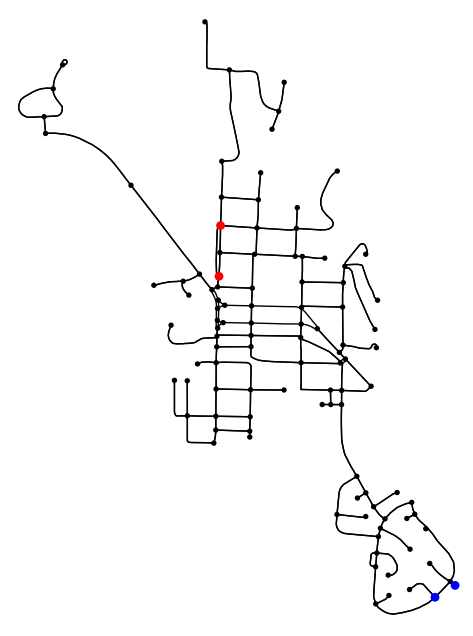

In [28]:
# location = 'Lyons Colorado'
# sup_dem_nodes = [(1,-4000),(30,4000),(4,-4000),(40,4000)]
# G = construct_orig_graph(location,sup_dem_nodes)
colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G.nodes(data=True)]
size =[ 40 if y['sup_dem'] != 0 else 15 for x,y in G.nodes(data=True)]
fig,ax = ox.plot_graph(G,show = False, close = False,node_size = size, node_color = colors,edge_color = 'black')
ax.set_facecolor('white')

##### Source and Sink Plot with Fire Plot

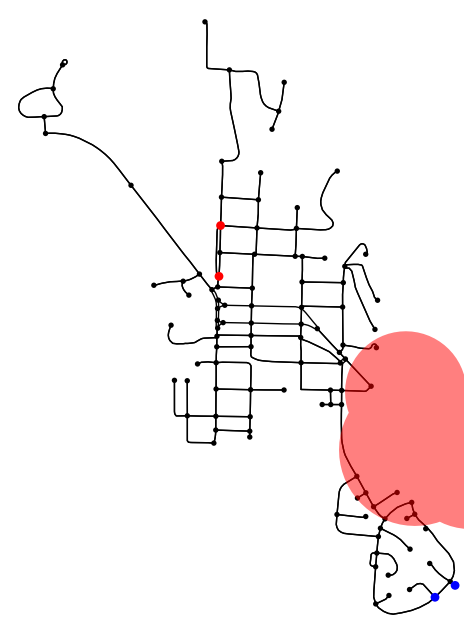

In [28]:
colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G.nodes(data=True)]
size =[ 40 if y['sup_dem'] != 0 else 15 for x,y in G.nodes(data=True)]
fig,ax = ox.plot_graph(G,show = False, close = False,node_size = size, node_color = colors,edge_color = 'black')

time_int = -1
###code to plot just the fire polygon
# fig,ax = plt.subplots()
# x,y = fire_poly_mat[time_int].exterior.xy
# ax.fill(x,y,'r', alpha = 0.5)

if fire_poly_mat[time_int].geom_type == 'Polygon':
    x,y = fire_poly_mat[time_int].exterior.xy
    ax.fill(x,y,'r', alpha = 0.5)
else:
    for geom in fire_poly_mat[time_int].geoms:  
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')

ax.set_facecolor('white')
# plt.show()
# plt.savefig('lyons_fire_init_ex.png')

##### Flow Plots

###### Initial Evacuation Flow Plot

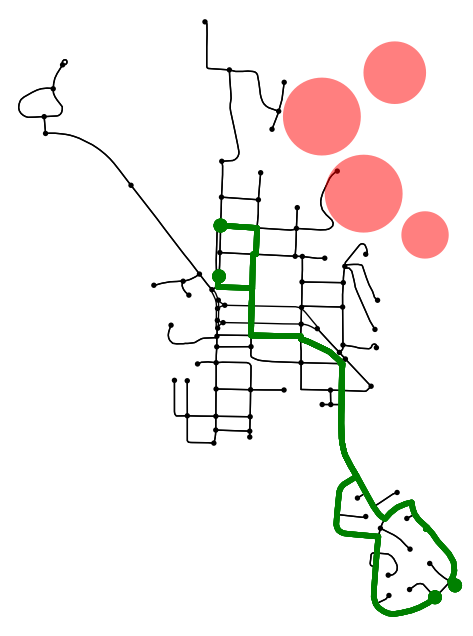

In [61]:
orig_paths = ten_to_orig_paths(ten_s_t_flow,ten_s_t, G)
cl = np.array(ox.plot.get_colors(len(orig_paths),cmap = "tab20",return_hex = True))
colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G.nodes(data=True)]
size =[ 50 if y['sup_dem'] != 0 else 15 for x,y in G.nodes(data=True)]
fig, ax = ox.plot_graph_routes(G, orig_paths, edge_color = 'black', node_color = colors, route_colors='green', 
                               route_linewidth=0.5, node_size = size, show = False, close = False, route_alpha = 1)

time_int = -1
if fire_poly_mat[time_int].geom_type == 'Polygon':
    x,y = fire_poly_mat[time_int].exterior.xy
    ax.fill(x,y,'r', alpha = 0.5)
else:
    for geom in fire_poly_mat[time_int].geoms:  
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')


ax.set_facecolor('white')
# fig.patch.set_alpha(0)
# plt.title('Street Network Lyons, Colorado')
# plt.savefig('lyons_multi_example_w_fire.png')

###### Updated Evacuation Flow Plot

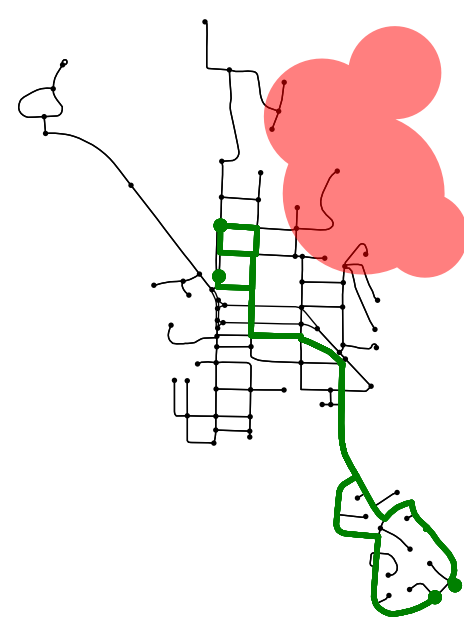

In [60]:
orig_paths_update = ten_to_orig_paths(colored_max_flow_ten_merg,merged_tens, G)
cl = np.array(ox.plot.get_colors(len(orig_paths_update),cmap = "tab20",return_hex = True))
colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G.nodes(data=True)]
size =[ 50 if y['sup_dem'] != 0 else 15 for x,y in G.nodes(data=True)]
fig, ax = ox.plot_graph_routes(G, orig_paths_update, edge_color = 'black', node_color = colors, route_colors='green', 
                               route_linewidth=0.5, node_size = size, show = False, close = False, route_alpha = 1)

time_int = -1
if fire_mat_poly_update[time_int].geom_type == 'Polygon':
    x,y = fire_mat_poly_update[time_int].exterior.xy
    ax.fill(x,y,'r', alpha = 0.5)
else:
    for geom in fire_mat_poly_update[time_int].geoms:  
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')


ax.set_facecolor('white')

###### Flow Over Time Plot

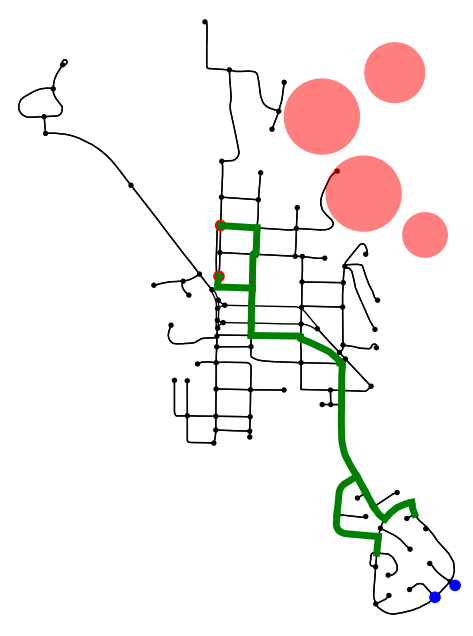

In [86]:
end_time_int = 20
orig_nodes_len =len(G.nodes)
flow_edges = [(x[0],x[1]) for x in ten_s_t_flow.edges(data = True) if ten_s_t_flow[x[0]][x[1]]['color'] == (1,0,0)]
flow_edges.sort(key=lambda tup: tup[0])

orig_flow_edges = flow_at_time_int(ten_s_t_flow, flow_edges, G, end_time_int)

flow_colors = ['green' if (x,y) in orig_flow_edges else 'black' for x,y,z in G.edges(data=True)]
sup_dem_colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G.nodes(data=True)]
size =[ 70 if y['sup_dem'] != 0 else 15 for x,y in G.nodes(data=True)]

fig, ax = ox.plot_graph(G, edge_color = 'black', node_color = colors, edge_linewidth = 1, node_size = size, show = False, close = False)

for i, (u, v, d) in enumerate(G.edges(data=True)):
    if (u,v) in orig_flow_edges:
        ox.plot_graph_route(G, (u, v), route_color=flow_colors[i], route_linewidth = 5, orig_dest_size = 15, ax=ax, route_alpha = 1, show=False,close=False)

if fire_poly_mat[end_time_int].geom_type == 'Polygon':
    x,y = fire_poly_mat[end_time_int].exterior.xy
    ax.fill(x,y,'r', alpha = 0.5)
else:
    for geom in fire_poly_mat[end_time_int].geoms:  
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')


ax.set_facecolor('white')


# plt.savefig('lyons_orig_time_int_7.png')
plt.show()

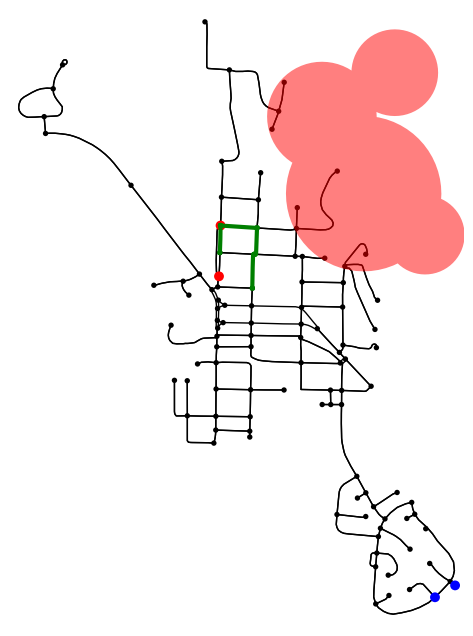

In [82]:
end_time_int = 7
orig_nodes_len =len(G.nodes)
flow_edges = [(x[0],x[1]) for x in colored_max_flow_ten_merg.edges(data = True) if colored_max_flow_ten_merg[x[0]][x[1]]['color'] == (1,0,0)]
flow_edges.sort(key=lambda tup: tup[0])

orig_flow_edges = flow_at_time_int(colored_max_flow_ten_merg, flow_edges, G, end_time_int)

flow_colors = ['green' if (x,y) in orig_flow_edges else 'black' for x,y,z in G.edges(data=True)]
sup_dem_colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G.nodes(data=True)]
size =[ 50 if y['sup_dem'] != 0 else 15 for x,y in G.nodes(data=True)]

fig, ax = ox.plot_graph(G, edge_color = 'black', node_color = colors, edge_linewidth = 1, node_size = size, show = False, close = False)

for i, (u, v, d) in enumerate(G.edges(data=True)):
    if (u,v) in orig_flow_edges:
        ox.plot_graph_route(G, (u, v), route_color=flow_colors[i], route_linewidth = 3, orig_dest_size = 15, ax=ax, route_alpha = 1, show=False,close=False)

if fire_mat_poly_update[end_time_int].geom_type == 'Polygon':
    x,y = fire_mat_poly_update[end_time_int].exterior.xy
    ax.fill(x,y,'r', alpha = 0.5)
else:
    for geom in fire_mat_poly_update[end_time_int].geoms:  
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')


ax.set_facecolor('white')


plt.savefig('lyons_update_time_int_7.png')
plt.show()

### Amador California

In [ ]:
location_2 = 'Amador California'
# location_2 = (121.02771, 38.217951, -120.072333, 38.709029)
# location_2 = ox.geocode_to_gdf("Amador California")
sup_dem_nodes_2 = [(30,40),(55,40),(45,-30),(40,-50)]
G_2 = construct_orig_graph(location_2,sup_dem_nodes_2,tolerance = 500)
fire_origin_radii_2 = [(38.584, -120.534,0.35),(38.32974, -120.70418,0.01),(38.334802, -120.665415,0.02)]


num_time_ints_2, max_flow_2, flow_dict_2, flow_ten_2, full_TEN_2,fire_poly_mat_2 = det_num_int(G_2, 60, fire_origin_radii_2)
print('Number of Time Intervals:',num_time_ints_2)
print('Flow Value:', max_flow_2)

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Supply and Demand Values Added
Time to Build Original Network:  7.3595099449157715  seconds
Feasability Check Completed: 0.0 seconds
Longest Shortest Path Deteremined: 0.0 seconds
Time to do Fire Poly for Time Horizon 2320: 784.4481673240662
Time to build TEN for T = 2320: 4.432680130004883
Add Super Source and Sink Time:  2.6271939277648926
Time for Max Flow Algorithm 191.71918392181396 seconds
----------------------------------------------------------------------
Time to do Fire Poly for Time Horizon 2321: 0.3143153190612793
Time to build TEN for T = 2321: 9.064517259597778
Add Super Source and Sink Time:  1.636026382446289
Time for Max Flow Algorithm 202.82501196861267 seconds
----------------------------------------------------------------------
Time to do Fire Poly for Time Horizon 2322: 0.38071513175964355
Time to build TEN for T = 2322: 4.8694422245025635
Add Super Source and Sink Ti

#### Plots

In [ ]:
colors_2=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'white' for x,y in G_2.nodes(data=True)]
fig_2,ax_2 = ox.plot_graph(G_2,show = False, close = False,node_size = 5, node_color = colors_2)
plt.show()

In [ ]:
# orig_paths_2 = ten_to_orig_paths(flow_ten_2,full_TEN_2, G_2)
cl_2 = np.array(ox.plot.get_colors(len(orig_paths_2),cmap = "tab20",return_hex = True))
fig_2, ax_2 = ox.plot_graph_routes(G_2, orig_paths_2, edge_color = 'black', node_color = 'black',route_colors=cl_2, route_linewidth=3, node_size=20, show = False, close = False, route_alpha = 1)

if fire_poly_mat_2[-1].geom_type == 'Polygon':
    x,y = fire_poly_mat_2[-1].exterior.xy
    ax_2.fill(x,y,'r', alpha = 0.5)
else:
    for geom in fire_poly_mat_2[-1].geoms:  
        xs, ys = geom.exterior.xy    
        ax_2.fill(xs, ys, alpha=0.5, fc='r', ec='none')


ax_2.set_facecolor('white')
# fig.patch.set_alpha(0)
# plt.title('Street Network Lyons, Colorado')
# plt.savefig('lyons_multi_example_w_fire.png')

### Greece Example

#### Initial Evaucation Plan

In [64]:
location_3 = ox.geocode_to_gdf("Alexandroupolis Greece")
# sup_dem_nodes_3 = [(20,40),(30,40),(55,-30),(40,-50)]
# sup_dem_nodes_3 = [(20,40),(30,40),(95,-30),(50,-50)]
sup_dem_nodes_3 = [(20,10),(30,40),(50,-50)]
G_3 = construct_orig_graph(location_3,sup_dem_nodes_3)
fire_origin_radii_3 = [(40.855034,25.879306,0.4)]

num_time_ints_3, max_flow_3, flow_dict_3, ten_s_t_flow_3, ten_s_t_3, rmvd_nodes_mat_3, edge_dist_mat_3, fire_poly_mat_3 = det_num_int(G_3, 40, fire_origin_radii_3, step_size = 10)
print('Number of Time Intervals:',num_time_ints_3)
print('Flow Value:', max_flow_3)

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Supply and Demand Values Added
Time to Build Original Network:  2.4098877906799316  seconds
Feasability Check Completed: 0.0 seconds
Longest Shortest Path Deteremined: 0.0 seconds
Time to do Fire Poly for Time Horizon 158: 355.7047815322876
Time to build TEN for T = 158: 2.4373409748077393
Add Super Source and Sink Time:  0.5383749008178711
Time for Max Flow Algorithm 5.145495176315308 seconds
----------------------------------------------------------------------
Construct Colored Time Expanded Network
Time to build TEN for T = 167: 1.0537903308868408
Add Super Source and Sink Time:  1.6225359439849854
Time to color edges with Flow in TEN: 0.15743136405944824
Number of Time Intervals: 167
Flow Value: 50.0


#### Plots

##### Source and Sink Plot

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Supply and Demand Values Added
Time to Build Original Network:  1.6245923042297363  seconds


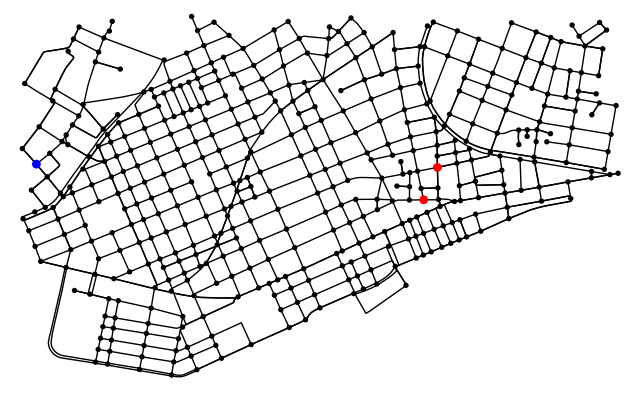

In [63]:
location_3 = ox.geocode_to_gdf("Alexandroupolis Greece")
sup_dem_nodes_3 = [(20,40),(30,40),(50,-50)]
G_3 = construct_orig_graph(location_3,sup_dem_nodes_3)

colors_3=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G_3.nodes(data=True)]
size_3 =[40 if y['sup_dem'] != 0 else 15 for x,y in G_3.nodes(data=True)]
fig_3,ax_3 = ox.plot_graph(G_3,show = False, close = False,node_size = size_3, node_color = colors_3,edge_color = 'black')
ax_3.set_facecolor('white')

##### Source and Sink with Fire

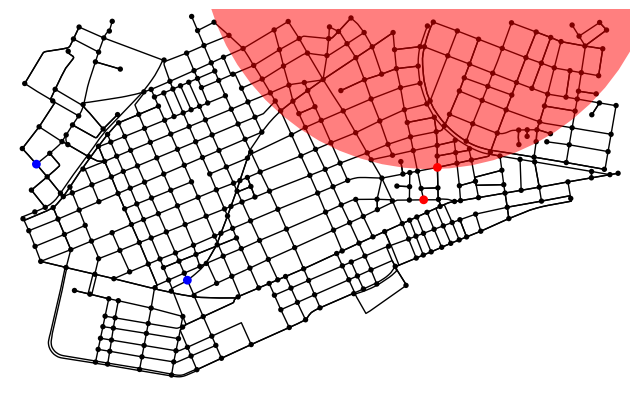

In [34]:
colors_3=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G_3.nodes(data=True)]
size_3 =[ 40 if y['sup_dem'] != 0 else 15 for x,y in G_3.nodes(data=True)]
fig_3,ax_3 = ox.plot_graph(G_3,show = False, close = False,node_size = size_3, node_color = colors_3,edge_color = 'black')

time_int = -1
if fire_poly_mat_3[time_int].geom_type == 'Polygon':
    x_3,y_3 = fire_poly_mat_3[time_int].exterior.xy
    ax_3.fill(x_3,y_3,'r', alpha = 0.5)
else:
    for geom in fire_poly_mat_3[time_int].geoms:  
        xs_3, ys_3 = geom.exterior.xy    
        ax_3.fill(xs_3, ys_3, alpha=0.5, fc='r', ec='none')

ax_3.set_facecolor('white')
        
plt.show()

##### Flow Plots

###### Initial Evacuation Plan Flow Plot

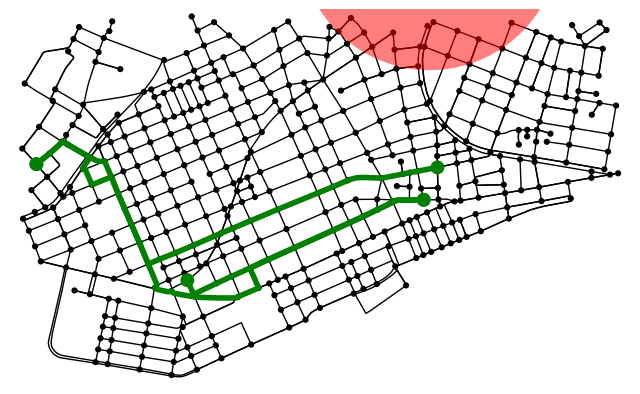

In [56]:
orig_paths_3 = ten_to_orig_paths(ten_s_t_flow_3,ten_s_t_3, G_3)
cl_3 = np.array(ox.plot.get_colors(len(orig_paths_3),cmap = "tab20",return_hex = True))
colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in G_3.nodes(data=True)]
size =[ 50 if y['sup_dem'] != 0 else 15 for x,y in G_3.nodes(data=True)]
fig, ax = ox.plot_graph_routes(G_3, orig_paths_3, edge_color = 'black', node_color = 'black',route_colors='green', 
                               route_linewidth=3, node_size=20, show = False, close = False, route_alpha = 1)

time_int_3 = 0

if fire_poly_mat_3[time_int].geom_type == 'Polygon':
    x,y = fire_poly_mat_3[time_int].exterior.xy
    ax.fill(x,y,'r', alpha = 0.5)
else:
    for geom in fire_poly_mat_3[time_int].geoms:  
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')


ax.set_facecolor('white')
# fig.patch.set_alpha(0)
# plt.title('Street Network Lyons, Colorado')
# plt.savefig('greece_multi_example.png')

###### Updated Evacuation Plan Flow Plot

# Testing Junk

## Dynamic Evac Plan Update

#### taken from networkx source code

In [149]:
res_ten = nx.build_residual_network(full_TEN,capacity = 'upper')

In [ ]:
def augment(path):
        """Augment flow along a path from s to t."""
        # Determine the path residual capacity.
        flow = inf
        it = iter(path)
        u = next(it)
        for v in it:
            attr = R_succ[u][v]
            flow = min(flow, attr["capacity"] - attr["flow"])
            u = v
        if flow * 2 > inf:
            raise nx.NetworkXUnbounded("Infinite capacity path, flow unbounded above.")
        # Augment flow along the path.
        it = iter(path)
        u = next(it)
        for v in it:
            R_succ[u][v]["flow"] += flow
            R_succ[v][u]["flow"] -= flow
            u = v
        return flow

#### toy example to test functionality

Time to build TEN for T = 8: 0.0


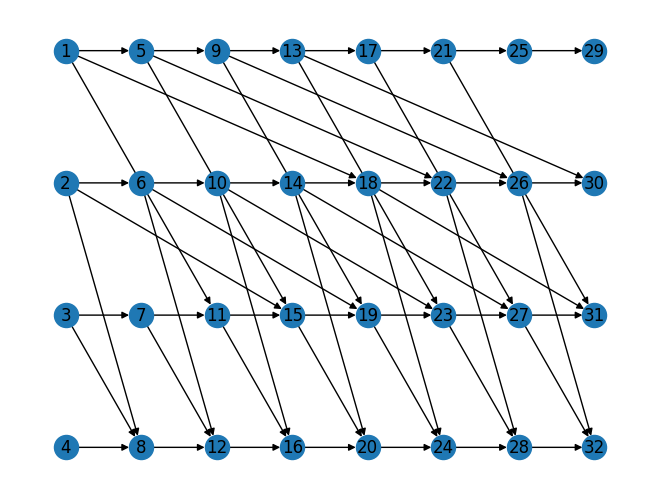

In [22]:
toy_net = nx.DiGraph()
toy_net.add_nodes_from(range(4))
toy_net.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)], cost = 0)
toy_net[0][1]['travel_time'] = 4
toy_net[0][2]['travel_time'] = 2
toy_net[1][2]['travel_time'] = 3
toy_net[1][3]['travel_time'] = 1
toy_net[2][3]['travel_time'] = 1
toy_net[0][1]['upper'] = 3
toy_net[0][2]['upper'] = 4
toy_net[1][2]['upper'] = 3
toy_net[1][3]['upper'] = 2
toy_net[2][3]['upper'] = 4
toy_net.nodes[0]['sup_dem'] = 9
toy_net.nodes[1]['sup_dem'] = 2
toy_net.nodes[2]['sup_dem'] = -2
toy_net.nodes[3]['sup_dem'] = -9

test_copies = 8
test_time_int = 1
ten = nx.DiGraph()

test_ten = time_expand_with_removal_dyn(toy_net, ten, test_time_int, 0, test_copies)
pos = nx.multipartite_layout(test_ten, subset_key="level")
nx.draw(test_ten, pos, with_labels = True)

In [26]:
list(toy_net.edges(data = True))

[(0, 1, {'cost': 0, 'travel_time': 4, 'upper': 3}),
 (0, 2, {'cost': 0, 'travel_time': 2, 'upper': 4}),
 (1, 2, {'cost': 0, 'travel_time': 3, 'upper': 3}),
 (1, 3, {'cost': 0, 'travel_time': 1, 'upper': 2}),
 (2, 3, {'cost': 0, 'travel_time': 1, 'upper': 4})]

In [27]:
toy_net_2 = nx.DiGraph()
toy_net_2.add_nodes_from(range(4))
toy_net_2.add_edges_from([(1,2),(1,3),(2,3)], cost = 0)
toy_net_2[1][2]['travel_time'] = 1
toy_net_2[1][3]['travel_time'] = 3
toy_net_2[2][3]['travel_time'] = 3
toy_net_2[1][2]['upper'] = 1
toy_net_2[1][3]['upper'] = 3
toy_net_2[2][3]['upper'] = 2
toy_net_2.nodes[0]['sup_dem'] = 9
toy_net_2.nodes[1]['sup_dem'] = 2
toy_net_2.nodes[2]['sup_dem'] = -2
toy_net_2.nodes[3]['sup_dem'] = -9

In [41]:
new_edges = toy_net_2.edges(data = True)
toy_net.remove_edges_from(list(toy_net_2.edges))
# nx.set_edge_attributes(toy_net, attrs)


In [48]:
toy_net.add_edges_from(new_edges)

In [51]:
toy_net.edges(data=True)

OutEdgeDataView([(0, 1, {'cost': 0, 'travel_time': 4, 'upper': 3}), (0, 2, {'cost': 0, 'travel_time': 2, 'upper': 4}), (1, 2, {'cost': 0, 'travel_time': 1, 'upper': 1}), (1, 3, {'cost': 0, 'travel_time': 3, 'upper': 3}), (2, 3, {'cost': 0, 'travel_time': 3, 'upper': 2})])

Add Super Source and Sink Time:  0.0010151863098144531


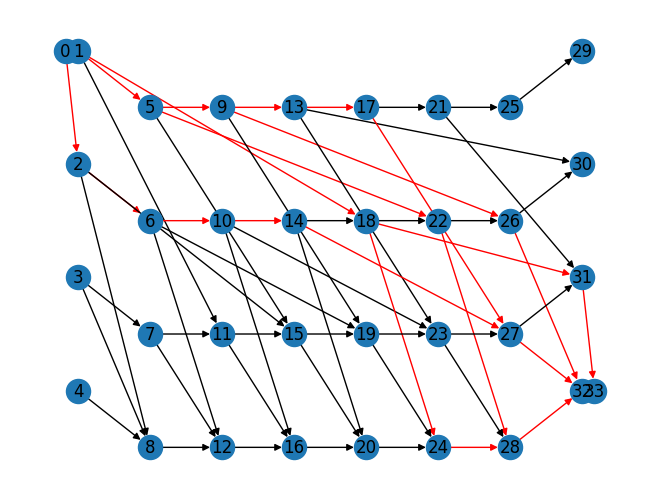

In [266]:
test_ten_s_t = s_t_ten = add_s_t(toy_net, test_ten, test_copies)
flow_value, flow_dict = nx.maximum_flow(test_ten_s_t.copy(), 0, max(list(test_ten_s_t.copy().nodes)),
                                        capacity = 'upper',flow_func = shortest_augmenting_path)


colored_max_flow_ten = color_max_flow(test_ten_s_t.copy(),flow_dict)
num_nodes = max(list(colored_max_flow_ten))
pos = nx.multipartite_layout(test_ten_s_t, subset_key="level")
pos[0]= np.array([pos[1][0]-0.05,pos[1][1]])
pos[max(test_ten_s_t.nodes)] = np.array([pos[max(test_ten_s_t.nodes)-1][0]+0.05,pos[max(test_ten_s_t.nodes)-1][1]])
colors = [colored_max_flow_ten[u][v]['color'] for u,v in colored_max_flow_ten.edges]
nx.draw(colored_max_flow_ten, pos, edge_color=colors,with_labels = True)

Add Super Source and Sink Time:  0.0


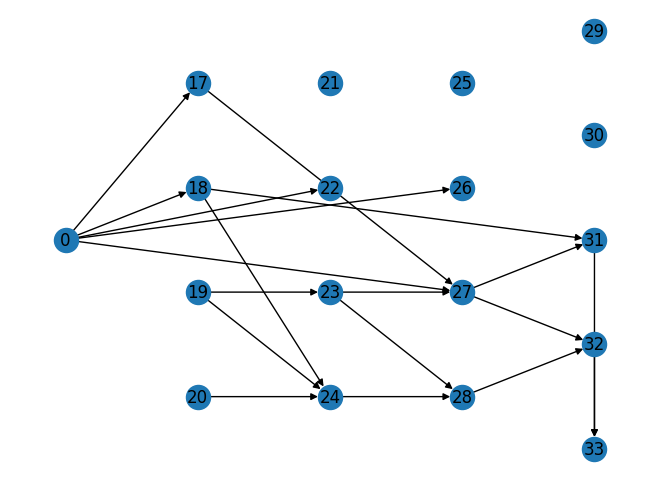

In [267]:
removed_nodes_mat_test = [[],[],[],[],[],[0,1],[0,1],[0,1]]
edge_dist_mat_test = [{},{},{},{},{}]
edge_dist_1 = {(0,1):9,(0,2):9,(1,2):9,(1,3):9,(2,3):9}
edge_dist_2 = {(0,1):9,(0,2):9,(1,2):9,(1,3):4,(2,3):6}
edge_dist_3 = {(0,1):9,(0,2):9,(1,2):9,(1,3):2,(2,3):4}
edge_dist_mat_test.append(edge_dist_1)
edge_dist_mat_test.append(edge_dist_2)
edge_dist_mat_test.append(edge_dist_3)

new_ten_test = evac_update(test_ten_s_t.copy(), toy_net, removed_nodes_mat_test, edge_dist_mat_test, 4, test_copies, 1, flow_dict)
# pos = nx.multipartite_layout(new_ten_test, subset_key="level")
# nx.draw(new_ten_test, pos, with_labels = True)

new_ten_test_s_t = s_t_ten = add_s_t(toy_net,new_ten_test, test_copies)
pos = nx.multipartite_layout(new_ten_test_s_t, subset_key="level")
nx.draw(new_ten_test_s_t, pos, with_labels = True)

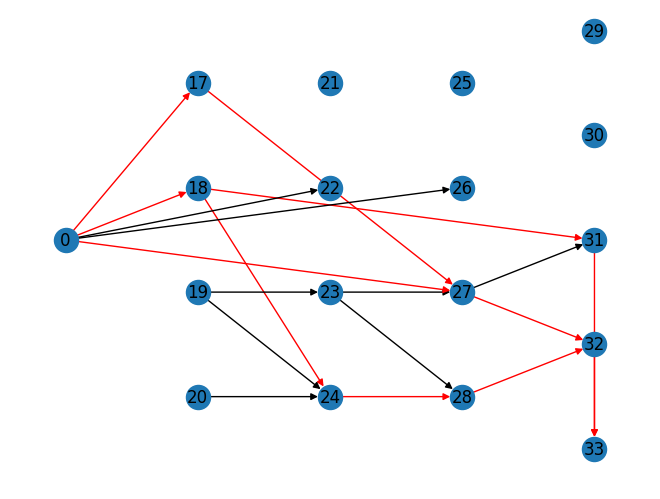

In [268]:
flow_value_2, flow_dict_2 = nx.maximum_flow(new_ten_test_s_t.copy(), 0, max(list(new_ten_test_s_t.copy().nodes)),
                                        capacity = 'upper',flow_func = shortest_augmenting_path)


colored_max_flow_ten_2 = color_max_flow(new_ten_test_s_t,flow_dict_2)
num_nodes = max(list(colored_max_flow_ten_2))
pos = nx.multipartite_layout(new_ten_test_s_t, subset_key="level")
# pos[0]= np.array([pos[1][0]-0.05,pos[1][1]])
# pos[max(new_ten_test_s_t.nodes)] = np.array([pos[max(new_ten_test_s_t.nodes)-1][0]+0.05,pos[max(new_ten_test_s_t.nodes)-1][1]])
colors = [colored_max_flow_ten_2[u][v]['color'] for u,v in colored_max_flow_ten_2.edges]
nx.draw(colored_max_flow_ten_2, pos, edge_color=colors,with_labels = True)

In [291]:
def merge_flow_dicts(dict1, dict2):
    merged_dict = dict1.copy()  # Create a copy of the first dictionary
    # print(merged_dict)
    # merged_dict = {}
    dict_set_1 = set(dict1)
    dict_set_2 = set(dict2)
    updated_nodes = dict_set_1.intersection(dict_set_2)

    # Set values in dict1 to zero if they're not present in dict2
    for node1 in list(updated_nodes):
        edges = dict1[node1]
        for node2, flow in edges.items():
            if node1 in dict2.keys() and node2 in dict2[node1].keys():
                if dict2[node1][node2] is not None:
                    merged_dict[node1][node2] = dict2[node1][node2]
            else:
                merged_dict[node1][node2] = 0
    
    return merged_dict

In [292]:
del flow_dict_2[0]
test_flow_dict = merge_flow_dicts(flow_dict, flow_dict_2)

In [293]:
test_flow_dict

{1: {5: 6, 18: 3, 11: 0},
 2: {6: 2, 15: 0, 8: 0},
 3: {7: 0, 8: 0},
 4: {8: 0},
 5: {9: 4, 22: 2, 15: 0},
 6: {10: 2, 19: 0, 12: 0},
 7: {11: 0, 12: 0},
 8: {12: 0},
 9: {13: 2, 26: 2, 19: 0},
 10: {14: 2, 23: 0, 16: 0},
 11: {15: 0, 16: 0},
 12: {16: 0},
 13: {17: 2, 30: 0, 23: 0},
 14: {18: 0, 27: 2, 20: 0},
 15: {19: 0, 20: 0},
 16: {20: 0},
 17: {21: 0, 27: 2},
 18: {22: 0, 31: 2, 24: 1},
 19: {23: 0, 24: 0},
 20: {24: 0},
 21: {25: 0, 31: 0},
 22: {26: 0, 28: 0},
 23: {27: 0, 28: 0},
 24: {28: 1},
 25: {29: 0},
 26: {30: 0, 32: 0},
 27: {31: 0, 32: 4},
 28: {32: 1},
 29: {},
 30: {},
 31: {33: 2},
 32: {33: 5},
 0: {1: 9, 2: 2},
 33: {}}

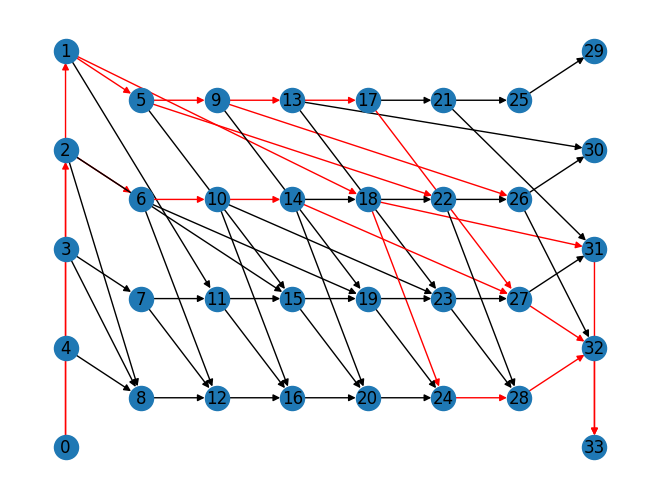

In [294]:
colored_max_flow_ten_3 = color_max_flow(test_ten_s_t.copy(),test_flow_dict)
num_nodes = max(list(colored_max_flow_ten_3))
pos = nx.multipartite_layout(test_ten_s_t.copy(), subset_key="level")
# pos[0]= np.array([pos[1][0]-0.05,pos[1][1]])
# pos[max(test_ten_s_t.nodes)] = np.array([pos[max(test_ten_s_t.nodes)-1][0]+0.05,pos[max(test_ten_s_t.nodes)-1][1]])
colors = [colored_max_flow_ten_3[u][v]['color'] for u,v in colored_max_flow_ten_3.edges]
nx.draw(colored_max_flow_ten_3, pos, edge_color=colors,with_labels = True)

## Dual Simplex Testing

In [ ]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

# nodes = [1, 2, 3, 4, 5, 6]
# edges = [[1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 6], [5, 6]]
# capacities = [2,4,6,8,2,5,5,7,8]

# capacities=np.array(capacities)
# nodes=np.array(nodes)

# G = nx.DiGraph()
# G.add_nodes_from(nodes)
# G.add_edges_from(edges)

edges = full_TEN.edges
caps = [full_TEN[x][y]['upper'] for x,y,z in full_TEN.edges(data=True)]
capacities=np.array(caps).transpose()
l_caps = [full_TEN[x][y]['lower'] for x,y,z in full_TEN.edges(data=True)]
lowers = np.array(l_caps).transpose()
c = []

sups = [x for x,y in G.nodes(data=True) if y['sup_dem'] > 0]
for (i,j) in edges:
    if i in sups:
        c.append(1)
    else: 
        c.append(0)

c=np.array(c)

incidence_matrix = -nx.incidence_matrix(full_TEN, oriented=True) 

A=incidence_matrix.toarray()
# print(np.shape(A))
A = np.delete(A,sups, axis = 0)
# print(np.shape(A))
b=np.zeros((np.shape(A)[1],1))
# print(np.shape(b))

# result = [] # final result
# for i in range(len(A)):
#     row = [] # the new row in new matrix
#     product = 0 # the new element in the new row
#     for v in range(len(A[i])):
#         product += A[i][v] *x[v]
#     print(product)
#     row.append(product) # append sum of product into the new row
        
#     result.append(row) # append the new row into the final result


# print(result)
# print(np.shape(c))
m=gp.Model()
x = m.addMVar((len(edges),), ub = capacities, lb = lowers) 
# print(x)
m.setObjective(c@x,GRB.MAXIMIZE)
m.addConstr(A@x==b)
m.addConstr(x>= 0)
m.optimize()

#### Other Testing Stuff

In [68]:
# import numpy as np
# import scipy.sparse as sp
# import networkx as nx
# import gurobipy as gp
# from gurobipy import GRB

# nodes = [1, 2, 3, 4, 5, 6]
# edges = [[1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 6], [5, 6]]
# capacities = [2,4,6,8,2,5,5,7,8]

# capacities=np.array(capacities)
# nodes=np.array(nodes)

# G = nx.DiGraph()
# G.add_nodes_from(nodes)
# G.add_edges_from(edges)

# incidence_matrix = -nx.incidence_matrix(G, oriented=True) 

# A=incidence_matrix.toarray()
# b=np.zeros((np.shape(A)[1],1))

# c=[]

# for i in range(len(edges)):
#     if edges[i][0]==1:
#         c.append(1)
#     else: 
#         c.append(0)

# c=np.array(c)        
# x=capacities.transpose()
    

# m=gp.Model()
  
# m.setObjective(c@x,GRB.MAXIMIZE)
# m.addConstr(A@x==b)
# m.addConstr(x>= 0)
# m.optimize()

In [ ]:
import cplex
# import lpex3

cpx = cplex.Cplex()
cpx.read('Insert LP file here')  
# use the dual simplex   
cpx.parameters.lpmethod.set(cpx.parameters.lpmethod.values.dual)
cpx.solve()


In [ ]:
A  = nx.incidence_matrix(full_TEN, nodelist=None, edgelist=None, oriented=True, weight=None, dtype=None)

In [ ]:
num_rows, num_cols = A.shape

In [ ]:
B_u = np.identity(num_cols)
print(B_u.shape)
B_0 = -1*np.identity(num_cols)
print(B_0.shape)
B = np.concatenate([B_u,B_0], axis = 0)
print(B.shape)

# a = [[1,2,3],[4,5,6]]
# b = [[7,8,9],[10,11,12],[13,14,15]]
# ab = np.concatenate([a,b], axis = 0)
# ab

In [ ]:
edges = full_TEN.edges
# for (i,j) in edges:
#     if i == 0:
#         print('source')
caps = dict(zip(edges,[full_TEN[x][y]['upper'] for x,y in full_TEN.edges]))


In [ ]:
import pyomo.environ as pyo
solvername = 'glpk'
solverpath_exe = 'C:\\Users\\DillW\\winglpk-4.65\\glpk-4.65\\w64\\glpsol'

model = pyo.ConcreteModel()

# ARCS = range(0,len(edges))
NODES = range(0,max(full_TEN.nodes))
ORIG_NODES = range(1,max(full_TEN.nodes)-1)

model.x = pyo.Var(NODES, NODES, domain = pyo.NonNegativeReals)

def up_cap_con(model,i):
    return sum(model.x[i,j]  for j in NODES if (i,j) in edges) <= caps[i]

def low_cap_con(model,i):
    return sum(model.x[i,j] for j in NODES if (i,j) in edges) >= 0

def fb_con(model,i):
    return sum(model.x[j,i] for j in NODES if (j,i) in edges) - sum(model.x[i,j] for j in NODES if (i,j) in edges) == 0

def obj_rule(model):
    return sum(model.x[0,j] for j in NODES if (0,j) in edges)

model.obj = pyo.Objective(rule = obj_rule, sense = pyo.maximize)
model.up_cap = pyo.Constraint(NODES,rule = up_cap_con)
model.low_cap = pyo.Constraint(NODES,rule = low_cap_con)
model.flow = pyo.Constraint(ORIG_NODES,rule = fb_con)
# model.color = pyo.Constraint(NODES,rule = cap_con)
# model.slot = pyo.Constraint(NODES,rule = slot_con)

result = pyo.SolverFactory(solvername,executable=solverpath_exe).solve(model)

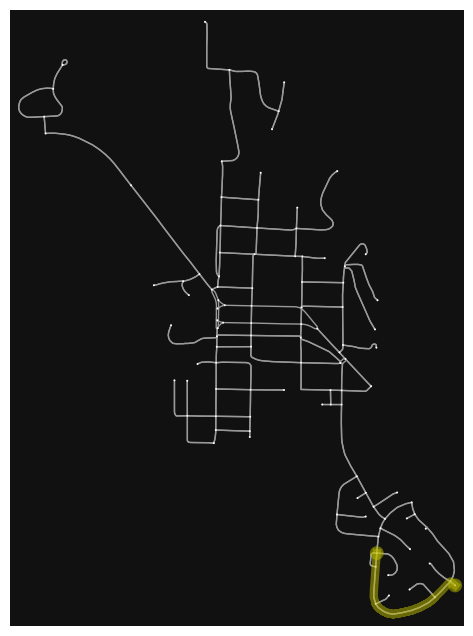

In [58]:
# colors_2=['red' if x in orig_paths[4] else 'white' for x,y in G.nodes(data=True)]
# fig,ax = ox.plot_graph(G,show = False, close = False,node_size = 25, node_color = colors_2)
# fig, ax = ox.plot_graph_route(G, orig_paths[2], route_color='y', route_linewidth=6, node_size=2, show = False, close = False)